In [21]:
import sys
sys.path.append('..')
import casadi
import numpy
import matplotlib.pyplot as plt
from Common.utils import *
param = get_dyna_CMA()

sampling frequency is: 1000 Hz


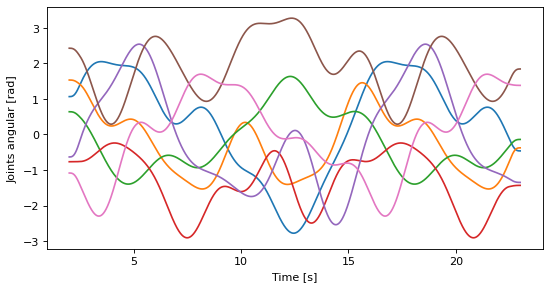

<Figure size 640x320 with 0 Axes>

In [22]:
from ArtificialDataGenerator.file import trans_format, Convert_q
            
ref_time, ref_q0, ref_dq, ref_ddq = trans_format(1)
ref_q = Convert_q('traj1', verbose=True)

# check if the traj span the whole state space
plt.figure(figsize=[8, 4], dpi=80)
for i in range(1,2):
    ref_time, ref_q0, ref_dq, ref_ddq = trans_format(i)
    ref_q = Convert_q('traj{}'.format(i), verbose=False)
plt.show()

In [23]:
from Common.M_matrix import M_panda
from Common.C_matrix import C_panda
from Common.G_vector import G_panda

q_dq = casadi.SX.sym("q_dq", 14)
M = M_panda(param, q_dq[:7], casadi.cos, casadi.sin)
C = C_panda(param, q_dq[:7], q_dq[7:], casadi.cos, casadi.sin)
G = G_panda(param, q_dq[:7], casadi.cos, casadi.sin)

M = casadi.vertcat(*M)
G = casadi.vertcat(*G)
C = casadi.vertcat(*C)

M = casadi.reshape(M, 7, 7)
G = casadi.reshape(G, 7, 1)
C = casadi.reshape(C, 7, 7)

G = casadi.simplify(G)
C = casadi.simplify(C)
M = casadi.simplify(M)

nx = 14  # state space \in R^14, first 7 dim are q, last 7 dim are qDot
na = 7
u = casadi.SX.sym('u', na)
dt = 0.001
q = q_dq[:7]
dq = q_dq[7:]
q_dq_dot_1 = dq
q_dq_dot_2 = casadi.inv(M) @ (u - C @ dq - G)

q_dq_dot = casadi.vertcat(q_dq_dot_1, q_dq_dot_2)

# dynamical system defined as a callable function
system = casadi.Function("sys", [q_dq, u], [q_dq_dot])

In [24]:
ode = {'x': q_dq, 'ode': q_dq_dot, 'p': u}
opts = {'tf': dt}
ode_solver = casadi.integrator('F', 'idas', ode, opts)

#### Collocation methods

In [25]:
def L(tau_col, tau, j):
    l = 1
    for k in range(len(tau_col)):
        if k!=j:
            l *= (tau-tau_col[k])/(tau_col[j]-tau_col[k]) 
    return l

def LgrInter(tau_col, tau, xk):
    z = 0
    for j in range(K):
        z += L(tau_col, tau, j)*xk[j,:]     
    return z

# collocation degree
K = 5

# collocation points (excluding 0)
tau_col = casadi.collocation_points(K,'radau')

# collocation points (including 0)
tau_col = [0]+tau_col

print(tau_col)

[0, 0.057104196114518224, 0.2768430136381237, 0.5835904323689168, 0.8602401356562193, 1.0]


In [26]:
tau = casadi.SX.sym('tau')

A = np.zeros((K+1,K+1))

for j in range(K+1):
    dLj = casadi.gradient(L(tau_col, tau, j), tau)
    dLj_fcn = casadi.Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j,k] = dLj_fcn(tau_col[k])

D = np.zeros((K+1,1))

for j in range(K+1):
    Lj = L(tau_col, tau, j)
    Lj_fcn = casadi.Function('Lj', [tau], [Lj])
    D[j] = Lj_fcn(1)

In [29]:
# Initialize empty list of constraints
g = []

# 01 - Your code here!
# States at all collocation points
X = casadi.SX.sym('X', nx, K+1)
# Initial state
x_init = casadi.SX.sym('x0', nx)
# control input
u = casadi.SX.sym('u', na)
# 01

# 02
# Append constraint to enforce initial state
g0 = X[:,0]-x_init
g.append(g0)
# 02

# 03
for k in range(1,K+1):
    gk = -dt*system(X[:,k], u)
    for j in range(K+1):
        gk += A[j,k]*X[:,j]
        
    g.append(gk)
# 03

# 04 - Your code here!    
g = casadi.vertcat(*g)
# 04

# 05
# dictionary for nlpsol object (no objective function required)
nlp = {'x':X.reshape((-1,1)), 'g':g, 'p':casadi.vertcat(x_init, u)}
# create nlpsol object (with ipopt)
S = casadi.nlpsol('S', 'ipopt', nlp)

In [30]:
# Define the initial condition
x_0 = np.random.randn(14,1)
# Define the input (for the moment consider u = 0)
u_k = np.random.randn(7,1)
# Initialize result list
res_x_oc = [x_0]

In [31]:
N_sim = 100
for i in range(N_sim):
    res_oc = S(lbg=0, ubg=0, p=casadi.vertcat(x_0, u_k))
    X_k = res_oc['x'].full().reshape(K+1,nx)
    x_next = X_k.T@D
    res_x_oc.append(x_next)
    x_0 = x_next
# Make an array from the list of arrays:
res_x_oc = np.concatenate(res_x_oc,axis=1)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      889
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      450

Total number of variables............................:       84
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  0.0000000e+00 1.27e-01 0.00e+00  -1.0 2.92e+00    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 3.03e-05 0.00e+00  -2.5 1.27e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 1.78e-14 0.00e+00  -5.7 1.01e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   1.7763568394002505e-14    1.7763568394002505e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.7763568394002505e-14    1.7763568394002505e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   2  0.0000000e+00 3.16e-05 0.00e+00  -2.5 1.30e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 4.97e-14 0.00e+00  -5.7 1.05e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.9737991503207013e-14    4.9737991503207013e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.9737991503207013e-14    4.9737991503207013e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 4
Number of inequality constraint Jacobian evaluations = 0
Number o

   3  0.0000000e+00 2.13e-14 0.00e+00  -5.7 1.10e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.1316282072803006e-14    2.1316282072803006e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.1316282072803006e-14    2.1316282072803006e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 4
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 3
Total CPU secs in IPOPT (w/o fun

   1  0.0000000e+00 1.42e-01 0.00e+00  -1.0 4.45e+00    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 3.52e-05 0.00e+00  -2.5 1.41e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 4.26e-14 0.00e+00  -5.7 1.17e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.2632564145606011e-14    4.2632564145606011e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.2632564145606011e-14    4.2632564145606011e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   1  0.0000000e+00 1.50e-01 0.00e+00  -1.0 5.43e+00    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 3.75e-05 0.00e+00  -2.5 1.48e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 2.84e-14 0.00e+00  -5.7 1.25e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.8421709430404007e-14    2.8421709430404007e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8421709430404007e-14    2.8421709430404007e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   0  0.0000000e+00 6.33e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 1.57e-01 0.00e+00  -1.0 6.42e+00    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 3.98e-05 0.00e+00  -2.5 1.55e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 2.22e-14 0.00e+00  -5.7 1.32e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.2204460492503131e-14    2.2204460492503131e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.2204460492503131e-14    2.2204460492503131e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequal

   1  0.0000000e+00 1.63e-01 0.00e+00  -1.0 7.24e+00    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 4.16e-05 0.00e+00  -2.5 1.60e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 4.26e-14 0.00e+00  -5.7 1.39e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.2632564145606011e-14    4.2632564145606011e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.2632564145606011e-14    4.2632564145606011e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   7.00us (  1.75us)   5.66us (  1.41us)         4
       nlp_g  |   1.16ms (290.50us)   1.16ms (290.44us)         4
    nlp_grad  | 712.00us (712.00us) 711.10us (711.10us)         1
  nlp_grad_f  |   8.00us (  1.60us)   7.79us (  1.56us)         5
  nlp_hess_l  |  20.11ms (  6.70ms)  20.10ms (  6.70ms)         3
   nlp_jac_g  |   8.77ms (  1.75ms)   8.78ms (  1.76ms)         5
       total  |  36.09ms ( 36.09ms)  35.76ms ( 35.76ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      889
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      450

Total number of variables............................:       84
                     variables with only lower bounds:        0
        

   2  0.0000000e+00 4.45e-05 0.00e+00  -2.5 1.71e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 2.84e-14 0.00e+00  -5.7 1.48e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.8421709430404007e-14    2.8421709430404007e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8421709430404007e-14    2.8421709430404007e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 4
Number of inequality constraint Jacobian evaluations = 0
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.87e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 1.78e-01 0.00e+00  -1.0 9.95e+00    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 4.48e-05 0.00e+00  -2.5 1.74e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 4.26e-14 0.00e+00  -5.7 1.49e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   4.2632564145606011e-14    4.2632564145606011e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.2632564145606011e-14    4.2632564145606011e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations          

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.08e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 1.80e-01 0.00e+00  -1.0 1.08e+01    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 4.39e-05 0.00e+00  -2.5 1.76e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 2.84e-14 0.00e+00  -5.7 1.46e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.8421709430404007e-14    2.8421709430404007e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8421709430404007e-14    2.8421709430404007e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations          

   2  0.0000000e+00 4.19e-05 0.00e+00  -2.5 1.75e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 2.84e-14 0.00e+00  -5.7 1.40e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.8421709430404007e-14    2.8421709430404007e-14
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8421709430404007e-14    2.8421709430404007e-14


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 4
Number of inequality constraint Jacobian evaluations = 0
Number o

   1  0.0000000e+00 1.76e-01 0.00e+00  -1.0 1.22e+01    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 3.79e-05 0.00e+00  -2.5 1.72e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 1.71e-13 0.00e+00  -5.7 1.27e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   1.7053025658242404e-13    1.7053025658242404e-13
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.7053025658242404e-13    1.7053025658242404e-13


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.31e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 1.70e-01 0.00e+00  -1.0 1.31e+01    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 3.66e-05 0.00e+00  -2.5 1.66e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 2.84e-13 0.00e+00  -5.7 1.20e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.8421709430404007e-13    2.8421709430404007e-13
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8421709430404007e-13    2.8421709430404007e-13


Number of objective function evaluations             = 4
Number of objective gradient evaluations          

   1  0.0000000e+00 1.62e-01 0.00e+00  -1.0 1.38e+01    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 4.84e-05 0.00e+00  -2.5 1.57e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 3.98e-13 0.00e+00  -5.7 1.60e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   3.9790393202565610e-13    3.9790393202565610e-13
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.9790393202565610e-13    3.9790393202565610e-13


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.45e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  0.0000000e+00 1.52e-01 0.00e+00  -1.0 1.45e+01    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 6.00e-05 0.00e+00  -2.5 1.47e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 7.39e-13 0.00e+00  -5.7 1.98e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)         

   1  0.0000000e+00 1.42e-01 0.00e+00  -1.0 1.50e+01    -  1.00e+00 1.00e+00h  1
   2  0.0000000e+00 7.02e-05 0.00e+00  -2.5 1.38e-01    -  1.00e+00 1.00e+00h  1
   3  0.0000000e+00 8.24e-13 0.00e+00  -5.7 2.31e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   8.2422957348171622e-13    8.2422957348171622e-13
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   8.2422957348171622e-13    8.2422957348171622e-13


Number of objective function evaluations             = 4
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 4
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

In [32]:
Q = 200
Q = Q*np.diag(np.ones(nx))

In [33]:
R = 0.001
R = np.diag(R*np.ones(na))

In [34]:
reference = casadi.SX.sym('reference',14,1)

In [35]:
# stage cost
stage_cost = (q_dq-reference).T@Q@(q_dq-reference)+ u.T@R@u
stage_cost_fcn = casadi.Function('stage_cost', [q_dq,reference,u], [stage_cost])

# terminal cost
terminal_cost = (q_dq-reference).T@Q@(q_dq-reference)
terminal_cost_fcn = casadi.Function('terminal_cost',[q_dq, reference],[terminal_cost])

In [36]:
N = 5
# state constraints
lb_x = -500*np.ones((nx,1))
ub_x = 500*np.ones((nx,1))
# input constraints, at least around 12
lb_u = -100*np.ones((na,1))
ub_u = 100*np.ones((na,1))

In [37]:
from casadi.tools import *

In [38]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1, K+1]),
    entry('u', shape=na, repeat=[N])
])

In [39]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

In [40]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [41]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

# Define the solver

In [42]:
# 01
x_init = SX.sym('x_init', nx)
q_qd_ref = SX.sym('q_dq_ref', nx*(N+1))

x0 = opt_x['x', 0, 0]

g.append(x0-x_init)
lb_g.append(np.zeros((nx,1)))
ub_g.append(np.zeros((nx,1)))
# 01

for i in range(N):
    # 02
    # objective
    J += stage_cost_fcn(opt_x['x', i, 0], q_qd_ref[i*nx:(i+1)*nx], opt_x['u', i])
    # 02
    
    # 03
    # equality constraints (system equation)
    for k in range(1,K+1):
        gk = -dt*system(opt_x['x',i,k], opt_x['u',i])
        for j in range(K+1):
            gk += A[j,k]*opt_x['x',i,j]
            
        g.append(gk)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
    # 03

    # 04
    x_next = horzcat(*opt_x['x',i])@D
    g.append(x_next - opt_x['x', i+1, 0])
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    # 04
    
# 05
J += terminal_cost_fcn(opt_x['x', N, 0], q_qd_ref[N*nx:(N+1)*nx])
# 05

# 06
g = vertcat(*g)

prob = {'f':J, 'x':vertcat(opt_x), 'g':g, 'p':vertcat(x_init, q_qd_ref)}

opts = {'ipopt.print_level':0, 'print_time':0}
mpc_solver = nlpsol('solver','ipopt',prob, opts)
# 06

In [43]:
ref_q_dq = np.concatenate([ref_q, ref_dq], axis=1)

In [44]:
# Define the initial condition
x_0 = ref_q_dq[0,:]
reference = ref_q_dq[:N+1, :]
reference = reference.flatten()
mpc_res = mpc_solver(p=vertcat(x_0, reference), lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)

In [45]:
opt_x_k = opt_x(mpc_res['x'])
X_k = horzcat(*opt_x_k['x',:,0,:])
U_k = horzcat(*opt_x_k['u',:])

Text(0.5, 0, 'time')

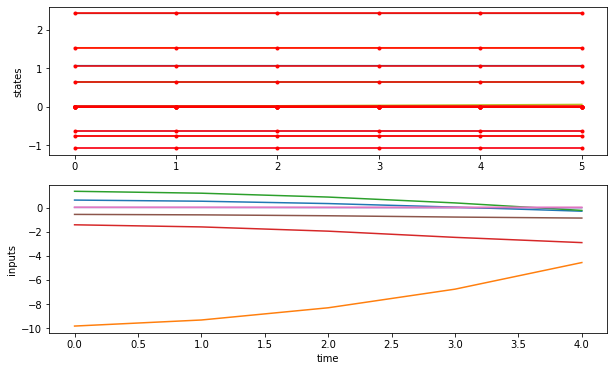

In [46]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(X_k.T)
ax[0].plot(ref_q_dq[:N+1, :], '.-r')
ax[1].plot(U_k.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time')

# Control loop

In [47]:
# Define the initial state
x_0 = ref_q_dq[0, :]
# Initialize result lists for states and inputs
res_x_mpc = [x_0.reshape(-1,1)]
res_u_mpc = []

# Set number of iterations
N_sim = 200

In [48]:
import tqdm
for i in tqdm.tqdm(range(N_sim)):
    # 01
    # solve optimization problem
    reference = ref_q_dq[i:i+N+1, :]
    reference = reference.flatten()
    mpc_res = mpc_solver(p=vertcat(x_0, reference), lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)
    # 01
        
    # 02
    # Extract the control input
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u', 0]
    # 02

    # 03
    # simulate the system
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    # 03
    
    # 04
    # Update the initial state
    x_0 = x_next
    # 04
    
    # 05 
    # Store the results
    res_x_mpc.append(x_next.full())
    res_u_mpc.append(u_k.full())
    # 05

# Make an array from the list of arrays:
res_x_mpc = np.concatenate(res_x_mpc, axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)

100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


Text(0.5, 0, 'time')

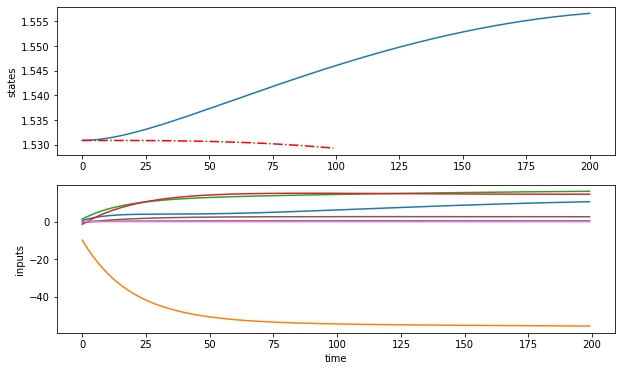

In [49]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(res_x_mpc[1,:].T)
ax[0].plot(ref_q_dq[:100,1], '-.r')
ax[1].plot(res_u_mpc.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time') # 20 time step means 4 seconds